In [ ]:
from gymnasium.envs.registration import register
import gymnasium as gym
from stable_baselines3 import *

In [ ]:
# tensorboard --logdir ./ppo_custom_env_tensorboard
register(
     id="my_envs/CustomGridWorld-v0",
     entry_point="my_envs:CustomGridWorldEnv",
     max_episode_steps=100,
)

env = gym.make("my_envs/CustomGridWorld-v0", render_mode="human")
model = A2C('MultiInputPolicy', env, verbose=1, tensorboard_log="./ppo_custom_env_tensorboard/")
model.learn(total_timesteps=100_000, log_interval=10, tb_log_name="first_run")
model.save("ppo_custom_env")

In [ ]:
model.policy

In [ ]:
# # save the model
# model.save("ppo_custom_env")

# # load the model
# model = PPO.load("ppo_custom_env")

In [ ]:
model = PPO.load("ppo_custom_env")

observation, info = env.reset(seed=42)
for _ in range(3000*5):
    action_arr, _states = model.predict(observation)
    action = action_arr.item()
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    if terminated or truncated:
        observation, info = env.reset()
        
env.close()

In [ ]:
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import *
from copy import deepcopy
from gymnasium.envs.registration import register
import pandas as pd
import talib

path = "/Users/newuser/Projects/robust-algo-trader/data/FOREX_EURUSD_1H_ASK.csv"
index_name = "Time"
df = pd.read_csv(path, parse_dates=True, index_col=index_name)
prices = df["Close"].values
sma = talib.SMA(prices, timeperiod=200)
# add sma to df
df["SMA"] = sma
# remove NaNs
df = df.dropna()


In [ ]:
df

In [ ]:


register(
    id='trade_env/CustomForex-v0',
    entry_point='trade_env:CustomForexEnv',
    #  max_episode_steps=100,
    kwargs={
        'df': deepcopy(df),
        'window_size': 24,
        'frame_bound': (24, len(df))
    }
)

env = gym.make(
              'trade_env/CustomForex-v0',
               df = deepcopy(df),
               window_size = 10,
               frame_bound = (10, 3000),
            #    num_envs=3,
            #    asynchronous=False,
            #    wrappers=None,
        )

In [ ]:

# from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log="./trade_env_tensorboard/")
model.learn(total_timesteps=30_000,  log_interval=10, tb_log_name="trade_name")

# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=1_000_000)

In [ ]:

import matplotlib.pyplot as plt

observation, info = env.reset(seed = 2)

while True:
    action, _state = model.predict(observation)
    # print("action:", action)
    # action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # observation, reward, done, info = env.step(action)
    # env.render()
    if terminated:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from enum import Enum
from sklearn.preprocessing import StandardScaler, PowerTransformer
import talib


    
class MyForexEnv(gym.Env):
    metadata = {"render_modes": ["human"]}
    
    def __init__(self,  df, window_size, frame_bound):
        assert len(frame_bound) == 2
        super().__init__()
        
        self.frame_bound = frame_bound
        # self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])
        # Inf should be a large enough upper bound
        INF = 1e9

        # spaces
        self.observation_space = spaces.Box(low=-INF, 
                                            high=INF,
                                            shape=self.shape, 
                                            dtype=np.float64)
        self.action_space = spaces.MultiDiscrete([2, 2, 4, 2])

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._current_tick = None
        self._last_trade_tick = None
        self._done = None
        
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        
        self._first_rendering = None
        self._first_time = None
        
        self.history = None
        self.trade_fee = 0.0003 
        self._seed()
        
        # self.reset()
        # self.step([0, 0, 13, 13])
        # self.step([1,  0, 10, 14])
    #    print("self._position_history:", self._position_history)
        # self.step(0)
        # self.step(0)
        # self.step(1)
        # self.step(1)
        # self.step(1)
        # self.step(0)
   
    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()
        sma = self.df.loc[:, 'SMA'].to_numpy()
        ema = self.df.loc[:, 'EMA'].to_numpy()
        
        prices = prices[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        diff = np.insert(np.diff(prices), 0, 0)
        sma = sma[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        ema = ema[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        
        signal_features = np.column_stack((sma, ema))
        # scale signal features
        # scaler = StandardScaler()
        # signal_features = scaler.fit_transform(signal_features)
        # transformer = PowerTransformer()
        # signal_features = transformer.fit_transform(signal_features)
        return sma, signal_features
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]     
    
    def reset(self, seed=None, options=None):
        print("reset\n")
        super().reset(seed=seed)
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1

        self._total_reward = 0.
        self._total_profit = 1.  # unit
        
        self._first_rendering = True
        self._first_time = True
        
        self.history = {}
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
        )
        self.existing_trade = None
        return observation, info


    def step(self, action):
        # print("action:", action)
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._update_profit(action)

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
        )
        
        # self._position_history.append(self._position)
        # if not self.history:
        #     self.history = {key: [] for key in info.keys()}
        # for key, value in info.items():
        #     self.history[key].append(value)
            
        return observation, step_reward, self._done, False, info


    def _calculate_reward(self, action):
        actual_state, trade_position, take_profit, stop_loss = action
        current_price = self.prices[self._current_tick]
        # initialize step reward to 0
        step_reward = 0  

        ## EXISTING TRADE STATE
        if self.existing_trade:
            existing_trade_position = self.existing_trade['trade_position']
            existing_tp = self.existing_trade['take_profit']
            existing_sl = self.existing_trade['stop_loss']
            entry_price = self.existing_trade['entry_price']
            
            
            price_diff = current_price - entry_price
            # if existing_trade_position is 1, and current_price triggers take_profit or stop_loss
            if existing_trade_position == 1: 
                # check if current_price is close to take_profit than stop_loss
                # if abs(current_price - existing_tp) < abs(current_price - existing_sl):
                if current_price >= existing_tp:
                    # step_reward += price_diff * 10000
                    step_reward += 1
                  
                elif current_price <= existing_sl:
                    # step_reward += price_diff * 5000
                    step_reward += 0.5
                elif price_diff >= 0:
                    step_reward += 1   
                else:
                    step_reward += 0.5       
            else:
                if current_price <= existing_tp:
                    step_reward += 1
                    # step_reward += price_diff * 10000
                elif current_price >= existing_sl:
                    step_reward += 0.5
                    # step_reward += price_diff * 5000
                elif price_diff <= 0:
                    step_reward += 1
                else:
                    step_reward += 0.5
            # Deductions
            # if actual_state is TRADE then deduct 0.5
            if actual_state == 1:
                step_reward -= 0.2
            # if SLdiff is greater than 2*TPdiff then deduct 0.3
            if abs(existing_sl - existing_tp) > 2 * abs(existing_tp - entry_price):
                step_reward -= 0.3                      
                  
        ## EXISTING IDLE STATE
        else:
            # if current_state is IDLE
            if actual_state == 0:
                if self._first_time:
                    step_reward += 0.2
                else:
                    step_reward += 0.5    
            # if current_state is TRADE
            else:
                step_reward += 0.6    
        
        print("\nstep_reward:", step_reward)     
        print("action:", action)
        return step_reward
    
    
    def _update_profit(self, action):
        actual_state, trade_position, take_profit, stop_loss = action
        if self.existing_trade:
            existing_trade_position = self.existing_trade['trade_position']
            existing_tp = self.existing_trade['take_profit']
            existing_sl = self.existing_trade['stop_loss']
            entry_price = self.existing_trade['entry_price']
            current_price = self.prices[self._current_tick]
            
            # if existing_trade_position is 1, and current_price triggers take_profit or stop_loss
            percent_price_diff = (current_price - entry_price)/ entry_price
            if existing_trade_position == 1: 
                if current_price >= existing_tp:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                elif current_price <= existing_sl:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
            else:
                if current_price <= existing_tp:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                elif current_price >= existing_sl:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                    
        if actual_state == 1 and self.existing_trade is None:
            self._first_time = False
            current_price = self.prices[self._current_tick]
            delta = 0.01
            if trade_position == 1:
                # if there is a buy trade
                take_profit_price = current_price + ((take_profit + 1) * delta)
                stop_loss_price = current_price - ((stop_loss + 1) * delta)
            else:
                # if there is a sell trade
                take_profit_price = current_price - ((take_profit + 1) * delta)
                stop_loss_price = current_price + ((stop_loss + 1) * delta)    
            
            self.existing_trade = {
                'trade_position': trade_position,
                'take_profit': take_profit_price,
                'stop_loss': stop_loss_price,
                'entry_price': current_price,
                'trade_tick': self._current_tick,
            }
            print("action:", action)
            print("total_profit:", self._total_profit)
            print("existing_trade:", self.existing_trade)
        
        
        
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    
env = MyForexEnv(
       df = deepcopy(df),
       window_size = 500,
       frame_bound = (500, 1_000),
    #    frame_bound = (1_000, 2_000),
    #    frame_bound = (7_000, 15_000),
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from enum import Enum
from sklearn.preprocessing import StandardScaler, PowerTransformer
import talib


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def switch(self):
        return Positions.Short if self == Positions.Long else Positions.Long
  
    
class MyForexEnv(gym.Env):
    metadata = {"render_modes": ["human"]}
    
    def __init__(self,  df, window_size, frame_bound):
        assert len(frame_bound) == 2
        super().__init__()
        
        self.frame_bound = frame_bound
        # self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])
        # Inf should be a large enough upper bound
        INF = 1e9

        # spaces
        self.observation_space = spaces.Box(low=-INF, 
                                            high=INF,
                                            shape=self.shape, 
                                            dtype=np.float64)
        self.action_space = spaces.Discrete(2)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._current_tick = None
        self._last_trade_tick = None
        self._done = None
        
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self.trade_fee = 0.0003 
        self._seed()
        
        # self.reset()
        # self.step(0)
        # self.step(0)
        # self.step(1)
        # self.step(1)
        # self.step(1)
        # self.step(0)
   
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]     
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Long
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        return observation, info

        
    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()
        sma = self.df.loc[:, 'SMA'].to_numpy()
        prices = prices[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        sma = sma[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        diff = np.insert(np.diff(prices), 0, 0)
        
        signal_features = np.column_stack(( sma, sma))
        # scale signal features
        # scaler = StandardScaler()
        # signal_features = scaler.fit_transform(signal_features)
        # transformer = PowerTransformer()
        # signal_features = transformer.fit_transform(signal_features)
        
        return prices, signal_features

    def step(self, action):
        # print("action:", action)
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._update_profit(action)

        if self._has_traded(action):
            self._position = self._position.switch()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        
        if not self.history:
            self.history = {key: [] for key in info.keys()}
        for key, value in info.items():
            self.history[key].append(value)
            
        return observation, step_reward, self._done, False, info


    def _calculate_reward(self, action):
        # initialize step reward to 0
        step_reward = 0  
        trade = self._has_traded(action)

        if trade:
            prev_trade_price = self.prices[self._last_trade_tick]
            current_price = self.prices[self._current_tick]
            price_diff = current_price - prev_trade_price

            if self._position == Positions.Short:
                if price_diff < 0:
                    # this is correct
                    step_reward += -price_diff * 10000
                else:
                    # give more penalty for wrong action
                    step_reward += -price_diff * 10000
                    
            elif self._position == Positions.Long:
                if price_diff > 0:
                    # this is correct
                    step_reward += price_diff * 10000
                else:
                    # give more penalty for wrong action
                    step_reward += price_diff * 10000
        
        # print("step_reward:", step_reward)
        # print("profit:", self._total_profit)
        return step_reward
    
    def _has_traded(self, action):
        return ((action == Actions.Buy.value and 
                 self._position == Positions.Short) or
            (action == Actions.Sell.value and 
             self._position == Positions.Long))
        
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_profit(self, action):
        if self._has_traded(action) or self._done:
            current_price = self.prices[self._current_tick]
            prev_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - prev_trade_price
            if self._position == Positions.Short:
                self._total_profit = self._total_profit * (1 - price_diff)
            elif self._position == Positions.Long:
                self._total_profit = self._total_profit * (1 + price_diff)
            
            # print("current_price:", self._total_profit ) 
            # quantity = self._total_profit / last_trade_price
            # self._total_profit = quantity * (current_price - self.trade_fee)

    
env = MyForexEnv(
       df = deepcopy(df),
       window_size = 100,
       frame_bound = (100, 3000),
    #    frame_bound = (2000, 5000),
)


In [ ]:
import gym
import pandas as pd
import numpy as np
from gym.utils import seeding
from gym import spaces
from enum import Enum
from typing import List, Dict
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')

class TradingEnvAction(Enum):
    STAY = 0
    BUY = 1
    SELL = 2
    CLOSE = 3

class TradingEnvTicket(object):
    def __init__(self, order_type, open_price, take_profit, stop_loss, lots):
        self.order_type = order_type
        self.open_price = open_price
        self.take_profit = take_profit
        self.stop_loss = stop_loss
        self.lots = lots
        self.trade_fee = 0.0003  # unit

class TradingEnvAccountInformation(object):
    def __init__(self, initial_balance):
        self.balance = initial_balance
        self.fixed_balance = initial_balance
        self.total_pips_buy = 10
        self.total_pips_sell = 10

    def items(self):
        return [('balance', self.balance), ('fixed_balance', self.fixed_balance), ('total_pips_buy', self.total_pips_buy), ('total_pips_sell', self.total_pips_sell)]


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound

        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit

        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(TradingEnvAction))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = TradingEnvAction.STAY.value
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (action != None):
            trade = True

        if trade:
            self._position = action
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,           
            position = Counter(self._position_history),
            last_15_position_predictions = self._position_history[-15:],
            position_predictions = self._position_history
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            marker = 'o'

            if position == TradingEnvAction.SELL.value:
                color = 'red'
                marker = 'v'
            elif position == TradingEnvAction.BUY.value:
                color = 'green'
                marker = '^'
            if position == TradingEnvAction.STAY.value:
                color = 'yellow'
                marker = 'o'
            elif position == TradingEnvAction.CLOSE.value:
                color = 'blue'
                marker = 'o'
            elif position == None:
                color = 'purple'                
            if color:
                plt.scatter(tick, self.prices[tick], marker=marker,color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        close_ticks = []
        stay_ticks = []        
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == TradingEnvAction.SELL.value:
                short_ticks.append(tick)
            elif self._position_history[i] == TradingEnvAction.BUY.value:
                long_ticks.append(tick)
            elif self._position_history[i] == TradingEnvAction.CLOSE.value:
                close_ticks.append(tick)
            elif self._position_history[i] == TradingEnvAction.STAY.value:
                stay_ticks.append(tick)

        
        plt.plot(short_ticks, self.prices[short_ticks], 'rv')
        plt.plot(long_ticks, self.prices[long_ticks], 'g^')
        plt.plot(close_ticks, self.prices[close_ticks], 'bo')
        plt.plot(stay_ticks, self.prices[stay_ticks], 'yo')        

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        step_reward = 0
        # print("p:",TradingEnvAction(self._position),"a:",TradingEnvAction(action),"-1:",TradingEnvAction(self._position_history[-1]),"c:",list(filter(None,self._position_history)))
        trade = False
        if (self._position != None and action != None):
            trade = True

        if trade:

            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            # print(action,self._position_history[-1:],price_diff)
            if list(filter(None,self._position_history)) == []:
                step_reward = -abs(price_diff)

            if (action == TradingEnvAction.BUY.value) or (action == TradingEnvAction.SELL.value):
                step_reward = abs(price_diff)

            if (action == TradingEnvAction.STAY.value) and (self._position_history[-1] == TradingEnvAction.BUY.value) and (current_price > last_trade_price ):
                step_reward += abs(price_diff)/15

            if (action == TradingEnvAction.STAY.value) and (self._position_history[-1] == TradingEnvAction.SELL.value) and (current_price < last_trade_price ):
                step_reward += abs(price_diff)/15

            if (action == TradingEnvAction.CLOSE.value) and (self._position_history[-1] == TradingEnvAction.SELL.value) and (current_price > last_trade_price ):
                step_reward += abs(price_diff)/15

            if (action == TradingEnvAction.CLOSE.value) and (self._position_history[-1] == TradingEnvAction.BUY.value) and (current_price < last_trade_price ):
                step_reward += abs(price_diff)/15                                            

            if (action == TradingEnvAction.STAY.value) and (self._position_history[-1] == TradingEnvAction.CLOSE.value):
                step_reward += -abs(price_diff) 
            
            if (action == TradingEnvAction.STAY.value) and (self._position_history[-1] == TradingEnvAction.STAY.value) and ((current_price < self.prices[-2]) or (current_price > self.prices[-2])):
                step_reward += abs(price_diff) 

            if (action == TradingEnvAction.STAY.value) and (self._position_history[-1] == TradingEnvAction.STAY.value):
                step_reward += abs(price_diff) 

    
        return step_reward


    def _update_profit(self, action):
        trade = False
        if (self._position != None and action != None):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == TradingEnvAction.BUY.value:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price



    def max_possible_profit(self):
        self.trade_fee = 0.0003  # unit
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = TradingEnvAction.SELL.value
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = TradingEnvAction.BUY.value

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self._position_history[-1] == TradingEnvAction.CLOSE.value:
                if position == TradingEnvAction.SELL.value:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self._position_history[-1] == TradingEnvAction.STAY.value:
                if position == TradingEnvAction.BUY.value:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from enum import Enum
from sklearn.preprocessing import StandardScaler, PowerTransformer
import talib


    
class MyForexEnv(gym.Env):
    metadata = {"render_modes": ["human"]}
    
    def __init__(self,  df, window_size, frame_bound):
        assert len(frame_bound) == 2
        super().__init__()
        
        self.frame_bound = frame_bound
        # self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])
        # Inf should be a large enough upper bound
        INF = 1e9

        # spaces
        self.observation_space = spaces.Box(low=-INF, 
                                            high=INF,
                                            shape=self.shape, 
                                            dtype=np.float64)
        self.action_space = spaces.MultiDiscrete([2, 2, 4, 2])

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._current_tick = None
        self._last_trade_tick = None
        self._done = None
        
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        
        self._first_rendering = None
        self._first_time = None
        
        self.history = None
        self.trade_fee = 0.0003 
        self._seed()
        
        # self.reset()
        # self.step([0, 0, 13, 13])
        # self.step([1,  0, 10, 14])
    #    print("self._position_history:", self._position_history)
        # self.step(0)
        # self.step(0)
        # self.step(1)
        # self.step(1)
        # self.step(1)
        # self.step(0)
   
    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()
        sma = self.df.loc[:, 'SMA'].to_numpy()
        ema = self.df.loc[:, 'EMA'].to_numpy()
        
        prices = prices[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        diff = np.insert(np.diff(prices), 0, 0)
        sma = sma[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        ema = ema[self.frame_bound[0] - self.window_size:self.frame_bound[1]]
        
        signal_features = np.column_stack((sma, ema))
        # scale signal features
        # scaler = StandardScaler()
        # signal_features = scaler.fit_transform(signal_features)
        # transformer = PowerTransformer()
        # signal_features = transformer.fit_transform(signal_features)
        return sma, signal_features
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]     
    
    def reset(self, seed=None, options=None):
        print("reset\n")
        super().reset(seed=seed)
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1

        self._total_reward = 0.
        self._total_profit = 1.  # unit
        
        self._first_rendering = True
        self._first_time = True
        
        self.history = {}
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
        )
        self.existing_trade = None
        return observation, info


    def step(self, action):
        # print("action:", action)
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._update_profit(action)

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
        )
        
        # self._position_history.append(self._position)
        # if not self.history:
        #     self.history = {key: [] for key in info.keys()}
        # for key, value in info.items():
        #     self.history[key].append(value)
            
        return observation, step_reward, self._done, False, info


    def _calculate_reward(self, action):
        actual_state, trade_position, take_profit, stop_loss = action
        current_price = self.prices[self._current_tick]
        # initialize step reward to 0
        step_reward = 0  

        ## EXISTING TRADE STATE
        if self.existing_trade:
            existing_trade_position = self.existing_trade['trade_position']
            existing_tp = self.existing_trade['take_profit']
            existing_sl = self.existing_trade['stop_loss']
            entry_price = self.existing_trade['entry_price']
            
            
            price_diff = current_price - entry_price
            # if existing_trade_position is 1, and current_price triggers take_profit or stop_loss
            if existing_trade_position == 1: 
                # check if current_price is close to take_profit than stop_loss
                # if abs(current_price - existing_tp) < abs(current_price - existing_sl):
                if current_price >= existing_tp:
                    # step_reward += price_diff * 10000
                    step_reward += 1
                  
                elif current_price <= existing_sl:
                    # step_reward += price_diff * 5000
                    step_reward += 0.5
                elif price_diff >= 0:
                    step_reward += 1   
                else:
                    step_reward += 0.5       
            else:
                if current_price <= existing_tp:
                    step_reward += 1
                    # step_reward += price_diff * 10000
                elif current_price >= existing_sl:
                    step_reward += 0.5
                    # step_reward += price_diff * 5000
                elif price_diff <= 0:
                    step_reward += 1
                else:
                    step_reward += 0.5
            # Deductions
            # if actual_state is TRADE then deduct 0.5
            if actual_state == 1:
                step_reward -= 0.2
            # if SLdiff is greater than 2*TPdiff then deduct 0.3
            if abs(existing_sl - existing_tp) > 2 * abs(existing_tp - entry_price):
                step_reward -= 0.3                      
                  
        ## EXISTING IDLE STATE
        else:
            # if current_state is IDLE
            if actual_state == 0:
                if self._first_time:
                    step_reward += 0.2
                else:
                    step_reward += 0.5    
            # if current_state is TRADE
            else:
                step_reward += 0.6    
        
        print("\nstep_reward:", step_reward)     
        print("action:", action)
        return step_reward
    
    
    def _update_profit(self, action):
        actual_state, trade_position, take_profit, stop_loss = action
        if self.existing_trade:
            existing_trade_position = self.existing_trade['trade_position']
            existing_tp = self.existing_trade['take_profit']
            existing_sl = self.existing_trade['stop_loss']
            entry_price = self.existing_trade['entry_price']
            current_price = self.prices[self._current_tick]
            
            # if existing_trade_position is 1, and current_price triggers take_profit or stop_loss
            percent_price_diff = (current_price - entry_price)/ entry_price
            if existing_trade_position == 1: 
                if current_price >= existing_tp:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                elif current_price <= existing_sl:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
            else:
                if current_price <= existing_tp:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                elif current_price >= existing_sl:
                    self._total_profit += percent_price_diff
                    # close the trade
                    self.existing_trade = None
                    
        if actual_state == 1 and self.existing_trade is None:
            self._first_time = False
            current_price = self.prices[self._current_tick]
            delta = 0.01
            if trade_position == 1:
                # if there is a buy trade
                take_profit_price = current_price + ((take_profit + 1) * delta)
                stop_loss_price = current_price - ((stop_loss + 1) * delta)
            else:
                # if there is a sell trade
                take_profit_price = current_price - ((take_profit + 1) * delta)
                stop_loss_price = current_price + ((stop_loss + 1) * delta)    
            
            self.existing_trade = {
                'trade_position': trade_position,
                'take_profit': take_profit_price,
                'stop_loss': stop_loss_price,
                'entry_price': current_price,
                'trade_tick': self._current_tick,
            }
            print("action:", action)
            print("total_profit:", self._total_profit)
            print("existing_trade:", self.existing_trade)
        
        
        
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    
env = MyForexEnv(
       df = deepcopy(df),
       window_size = 500,
       frame_bound = (500, 1_000),
    #    frame_bound = (1_000, 2_000),
    #    frame_bound = (7_000, 15_000),
)


In [ ]:
from sb3_contrib import RecurrentPPO
import torch as th

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[128, 128], vf=[128, 128]))

# policy_kwargs = dict(net_arch=[ dict(vf=[128, 128], pi=[64, 64])])

# policy_kwargs = dict( net_arch=dict(pi=[32, 32], vf=[32, 32]))
model = RecurrentPPO('MlpLstmPolicy', env, 
                    #  verbose=1,  
                    #  n_steps=256, 
                    #  gamma=0.95, 
                    #  n_epochs=500, 
                    #  target_kl=0.001, 
                     learning_rate=0.01,
                     tensorboard_log="./trade_env_tensorboard/")
model.learn(total_timesteps=1_000_000,  log_interval=10, tb_log_name="trade_name")

# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=1_000_000)

In [ ]:
model.learn(total_timesteps=140_000,  log_interval=10, tb_log_name="trade_name")

In [ ]:

import matplotlib.pyplot as plt

observation, info = env.reset(seed=0)

while True:
    action, _state = model.predict(observation)
    # action = env.action_space.sample()
    # print(action)
    observation, reward, terminated, truncated, info = env.step(action)
    # observation, reward, done, info = env.step(action)
    # env.render()
    if terminated:
        print("info:", info)
        break

# plt.cla()
# env.render_all()
# plt.show()

# EUR/USD Dataset Viz

In [ ]:
import matplotlib.pyplot as plt
df['SMA'].plot()

In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
# df = df.iloc[:1_000]
df = df.iloc[-7_000:]

# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
# rename the columns
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# convert the date_time column to datetime
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%Y%m%d %H:%M:%S.%f')
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# Rename Date_Time to Time
df = df.rename(columns={'Date_Time': 'Time'})
df.index = df['Time']
# remove the Time column
df = df.drop(['Time'], axis=1)


prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
df["EMA"] = talib.EMA(prices, timeperiod=200)
# df['TEMA'] = talib.TRIMA(prices, timeperiod=200*2)

df['ATR'] = talib.NATR(df['High'], df['Low'], df['Close'], timeperiod=200)
# df["EMA"] = ema
df = df.dropna()

In [ ]:
df

In [ ]:
df['Close'].plot()
# df['EMA'].plot()


In [ ]:
df['SMA'].plot()


In [ ]:
df['Close'].plot()


In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

scaler = StandardScaler()
copy_df = df.copy()

# scale all columns in copy_df 
copy_df['SMA'] = scaler.fit_transform(copy_df['SMA'].values.reshape(-1, 1))




In [ ]:
copy_df

In [ ]:
copy_df['SMA'].plot()


In [21]:
import numpy as np
import pandas as pd

# Define the parameters of the sine wave
frequency = 0.2 # cycles per day
amplitude = 0.3 # peak value
phase = 0 # initial angle
offset = 1 # vertical shift

# Define the time range and interval
start_time = "2022-01-01 00:00:00" # start date and time
end_time = "2022-01-31 23:00:00" # end date and time
time_interval = "1H" # hourly interval

# Create a time index using pandas date_range function
time_index = pd.date_range(start_time, end_time, freq=time_interval)

# Convert the time index to radians using numpy pi and timedelta function
time_radians = 2 * np.pi * frequency * (time_index - time_index[0]) / pd.Timedelta(days=1) + phase

# Calculate the sine values using numpy sin function and the parameters
sine_values = amplitude * np.sin(time_radians) + offset

# Create a dataframe using pandas DataFrame function and the time index and sine values
df = pd.DataFrame({"Time": time_index, "SMA": sine_values})

# Set the Time column as the index column using pandas set_index function
df = df.set_index("Time")



<AxesSubplot:xlabel='Time'>

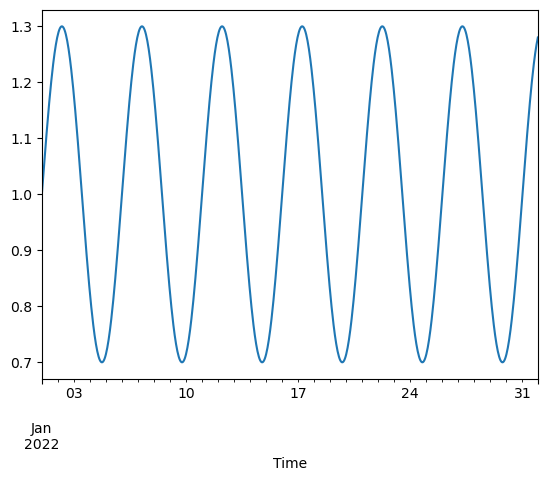

In [22]:
df['SMA'].plot()